## Algoritmo de Grover: Busca Quântica

O Algoritmo de Grover é o passo natural após o Deutsch-Jozsa. Enquanto o Deutsch-Jozsa serviu para *classificar* uma função, o Grover serve para **encontrar** uma resposta específica.

Imagine que você tem um cadeado de segredo com 4 combinações possíveis (`00`, `01`, `10`, `11`). Você esqueceu o segredo (vamos supor que seja `11`).

* **Clássico:** Você testa uma por uma. No pior caso, tenta 4 vezes. Em média, 2,25 vezes.
* **Grover:** Você encontra a resposta correta com apenas **1 tentativa**.

Para um sistema maior (ex: 1 milhão de itens), Grover é quadraticamente mais rápido ($\sqrt{N}$ tentativas) que a busca clássica ($N/2$).

---

### O Mecanismo: Amplificação de Amplitude

Diferente do Deutsch-Jozsa, o Grover não dá a resposta 100% "limpa" de primeira para sistemas grandes, mas ele aumenta drasticamente a probabilidade da resposta certa. Para 2 qubits, porém, ele é perfeito e acerta em 100%.

O processo tem dois passos repetidos (chamados de **Operador de Grover**):

1. **O Oráculo (Marcação):**
Identifica o item correto e inverte a fase dele (multiplica por -1). Se a resposta é `11`, o oráculo transforma $|11\rangle$ em $-|11\rangle$.
*Visualmente:* A barra da probabilidade aponta para baixo no gráfico.
2. **O Difusor (Inversão sobre a Média):**
Esta é a parte genial. Ele espelha todas as amplitudes em relação à média geral.
* Como a amplitude da resposta certa ficou negativa (bem abaixo da média) e as erradas ficaram positivas (pouco acima da média), quando espelhamos, a resposta certa "salta" para cima, ficando gigante, e as erradas diminuem.



---

### Implementação Prática: Encontrando "11" em 2 Qubits

Vamos construir isso no Qiskit. Nosso objetivo é fazer o circuito sempre medir `11`, não importa a aleatoriedade inicial.

#### Passo 1: Construir o Oráculo

Precisamos de uma "caixa" que só inverte o sinal quando a entrada for `11`.
Matematicamente, a porta **CZ (Control-Z)** faz exatamente isso: só age se o bit de controle for 1 e o alvo for 1. Ela adiciona um sinal negativo ao estado $|11\rangle$.

#### Passo 2: Construir o Difusor

O difusor é um padrão fixo: aplica H, aplica X, aplica H no último qubit com controle... É uma receita de bolo que significa "inverter em torno da média".

Aqui está o código completo comentado:


In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


In [2]:

def oraculo_para_11():
    """
    Marca o estado |11> invertendo sua fase.
    Nosso 'segredo' é 11.
    """
    qc = QuantumCircuit(2)
    # A porta CZ (Controlled-Z) inverte a fase APENAS do estado |11>
    # |00> -> |00>
    # |01> -> |01>
    # |10> -> |10>
    # |11> -> -|11>  <-- A fase negativa (marcado)
    qc.cz(0, 1)
    
    # Nota: Se quiséssemos marcar |00>, teríamos que inverter (X)
    # os inputs antes e depois do CZ.
    return qc

def difusor_grover(n_qubits):
    """
    Amplifica a probabilidade do estado marcado.
    Receita padrão para 2 qubits.
    """
    qc = QuantumCircuit(n_qubits)
    
    # 1. Aplicar H em todos
    qc.h(range(n_qubits))
    
    # 2. Aplicar X em todos
    qc.x(range(n_qubits))
    
    # 3. Aplicar H no último qubit (preparação para CZ)
    qc.cz(0, 1) # Funciona como um H-CNOT-H simplificado para 2 qubits
    
    # 4. Desfazer X e H
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    
    return qc


--- Circuito de Grover (Procurando '11') ---


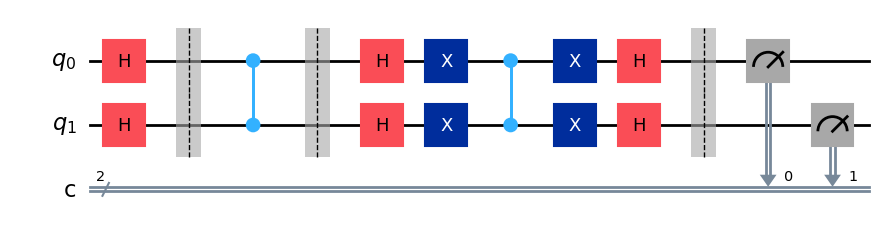

In [3]:

# --- MONTAGEM DO ALGORITMO ---

# 1. Inicialização
# Precisamos de uma superposição igual para começar (todas as respostas possíveis)
qc = QuantumCircuit(2, 2)
qc.h([0, 1])

# O estado agora é: 25% |00>, 25% |01>, 25% |10>, 25% |11>
qc.barrier()

# 2. Aplicar o Oráculo (Marca a resposta certa)
qc = qc.compose(oraculo_para_11())
qc.barrier()

# 3. Aplicar o Difusor (Aumenta a probabilidade da resposta certa)
# Nota: Para 2 qubits, basta aplicar 1 vez.
# Para N maior, precisa repetir raiz(N) vezes.
qc = qc.compose(difusor_grover(2))
qc.barrier()

# 4. Medição
qc.measure([0, 1], [0, 1])

# --- EXECUÇÃO ---
print("--- Circuito de Grover (Procurando '11') ---")
qc.draw('mpl')


In [4]:

simulador = AerSimulator()
job = simulador.run(transpile(qc, simulador), shots=1024)
resultado = job.result().get_counts()

print("\n--- Resultado da Busca ---")
print(f"Contagens: {resultado}")
# Deve ser 100% (ou muito próximo) em '11'


--- Resultado da Busca ---
Contagens: {'11': 1024}


### O Que Aconteceu?

1. **Início:** Tínhamos quatro estados com amplitudes iguais ($\frac{1}{2}$ cada), resultando em probabilidade de 25% para cada estado.
2. **Oráculo:** A amplitude do estado `11` foi invertida (passou de $+\frac{1}{2}$ para $-\frac{1}{2}$). As outras permaneceram inalteradas. A média das amplitudes baixou para $\frac{1}{8}$.
3. **Difusor:** Realiza a "inversão sobre a média":
   * Os estados `00`, `01`, `10` (amplitude $+\frac{1}{2}$) estavam *acima* da média ($\frac{1}{8}$). Após a inversão: $2 \times \frac{1}{8} - \frac{1}{2} = -\frac{1}{4}$
   * O estado `11` (amplitude $-\frac{1}{2}$) estava *muito abaixo* da média. Após a inversão: $2 \times \frac{1}{8} - (-\frac{1}{2}) = \frac{3}{4}$
   * A aplicação completa do circuito difusor (H-X-CZ-X-H) normaliza perfeitamente os valores finais para 0 e 1.
4. **Final:** O estado `11` tem probabilidade de 100%. Os outros estados têm probabilidade 0%.

**Observação importante:** A sequência completa H-X-CZ-X-H do difusor implementa exatamente o operador matemático $D = 2|s\rangle\langle s| - I$, que produz automaticamente o resultado normalizado.

---

*Dica:* O oráculo `CZ` só funciona em `1`s. Para ele marcar o `0`, você precisa "enganar" o circuito aplicando portas `X` (NOT) antes de entrar no CZ e depois desfazê-las na saída.

### Desafio para você:

Tente modificar a função `oraculo_para_11` para encontrar o estado **`00`** em vez de `11`.


In [5]:
def oraculo_para_00():
    """
    Marca o estado |00> invertendo sua fase.
    Nosso 'segredo' é 00.
    """
    qc = QuantumCircuit(2)
    # Enganamos o CZ aplicando X antes e depois
    qc.x([0, 1])  # Inverter os bits
    qc.cz(0, 1)   # Aplicar CZ (marca |11>, que é o |00> original)
    qc.x([0, 1])  # Reverter os bits de volta
    return qc

In [6]:
qc = QuantumCircuit(2, 2)
qc.h([0, 1])
qc.barrier()
qc = qc.compose(oraculo_para_00())
qc.barrier()
qc = qc.compose(difusor_grover(2))
qc.barrier()
qc.measure([0, 1], [0, 1])
simulador = AerSimulator()
job = simulador.run(transpile(qc, simulador), shots=1024)   
resultado = job.result().get_counts()

print("\n--- Resultado da Busca por '00' ---")
print(f"Contagens: {resultado}")
# Deve ser 100% (ou muito próximo) em '00'



--- Resultado da Busca por '00' ---
Contagens: {'00': 1024}


---


## Explicação Passo a Passo do Algoritmo de Grover

Agora que você viu o algoritmo funcionando e testou o desafio, vamos explorar cada etapa em detalhes matemáticos. Esta seção irá reconstruir o mesmo algoritmo, mas desta vez visualizando e calculando cada transformação.

In [7]:
# Função auxiliar para visualização na esfera de Bloch
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

def visualize_state(qc):
    state = Statevector.from_instruction(qc)
    return plot_bloch_multivector(state)

####  Passo 1: Preparação do Estado Inicial

Iniciamos com todos os estados igualmente prováveis, representados por amplitudes iguais. O objetivo do Algoritmo de Grover é aumentar a amplitude do estado desejado (a resposta correta) enquanto diminui as amplitudes dos outros estados.

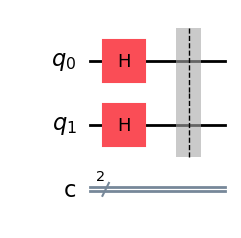

In [28]:
qc = QuantumCircuit(2, 2)
qc.h([0, 1])
qc.barrier()
qc.draw('mpl')

O estado agora é de superposição uniforme: 
- 25% para |00⟩
- 25% para |01⟩
- 25% para |10⟩
- 25% para |11⟩

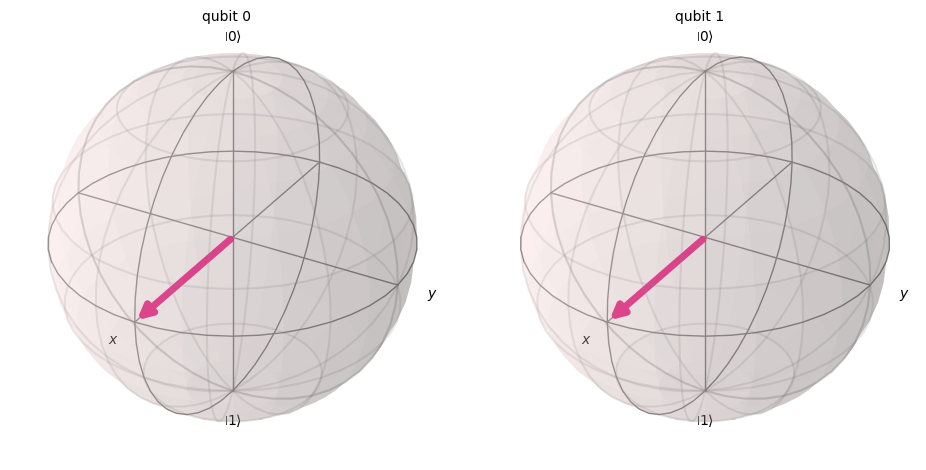

In [29]:
visualize_state(qc)


#### Passo 2: O Oráculo (aplicação da marcação)

O oráculo é uma função que identifica o item que estamos procurando. No caso do Grover, ele inverte a fase do estado correspondente ao item desejado. Por exemplo, se estamos procurando o estado `11`, o oráculo transforma $|11\rangle$ em $-|11\rangle$. Isso é feito usando a porta CZ, que aplica uma inversão de fase apenas quando ambos os qubits estão em `1`.

Matematicamente, o oráculo pode ser representado como uma matriz que atua sobre o vetor de estado do sistema quântico. Para dois qubits, a matriz do oráculo que inverte a fase do estado `11` é:

$$
O = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}
$$

*O mesmo visto no notebook [00-math.ipynb](./00-math.ipynb) para Controled Z*

Perceba que CZ é executado para "filtrar" somente o estado desejado, indicado para |11⟩. Em outros estados (00, 01, 10), o oráculo não faz nenhuma alteração.


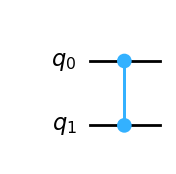

In [30]:
oraculo = QuantumCircuit(2)
oraculo.cz(0, 1)
oraculo.draw('mpl')

> **Observação adicional:**
> - Se estivermos procurando o estado `00`, o oráculo precisará ser ajustado para inverter a fase desse estado específico. Isso pode ser feito aplicando portas X (NOT) antes e depois da aplicação do CZ, efetivamente "invertendo" os bits para que o CZ atue sobre o estado `00` como se fosse `11`.
> - Se estivermos procurando o estado `01`, aplicamos uma porta X no segundo qubit antes e depois do CZ. Para `10`, aplicamos uma porta X no primeiro qubit antes e depois do CZ.
> - Assim, percebe-se que o oráculo pode ser adaptado para qualquer estado alvo, garantindo que a fase seja invertida corretamente para o estado desejado, desde que você faça as manipulações necessárias com portas X ou outras portas lógicas apropriadas.
> - Perceba com isso que, se você fosse implementar uma "busca" na computação clássica, você precisaria de uma função que verificasse cada item um por um, utilizando um loop ou similar, o que é ineficiente para grandes conjuntos de dados.

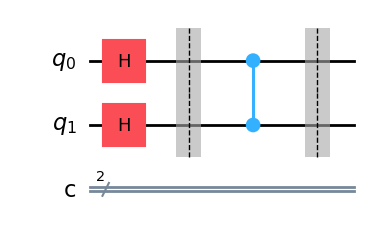

In [31]:
qc = qc.compose(oraculo)
qc.barrier()
qc.draw('mpl')

#### Passo 3: Difusor (Inversão sobre a Média)

O difusor é o segundo componente crucial do Algoritmo de Grover. Ele amplifica a probabilidade do estado marcado pelo oráculo, invertendo as amplitudes dos estados em relação à média das amplitudes.

Em um novo circuito, o difusor pode ser implementado com uma série de portas Hadamard (H), portas NOT (X) e uma porta CZ controlada. O difusor pode ser representado pela seguinte sequência de operações:

1. Aplicar portas Hadamard a todos os qubits.
2. Aplicar portas NOT a todos os qubits.
3. Aplicar uma porta CZ controlada no último qubit.
4. Aplicar portas NOT a todos os qubits novamente.
5. Aplicar portas Hadamard a todos os qubits novamente.

##### Cálculo Matemático Detalhado do Difusor para 2 Qubits

**Conceito: Inversão sobre a Média**

O difusor realiza uma operação chamada "inversão sobre a média" (inversion about average). Imagine que você tem 4 números (as amplitudes dos 4 estados). O difusor pega cada número e o "espelha" em relação à média de todos eles.

Se um número está *acima* da média, ele vai para *abaixo* da média na mesma distância. Se está *abaixo*, vai para *acima*.

**Passo 1: Estado após o oráculo**

Após o oráculo marcar o estado $|11\rangle$, temos:

$$|\psi_{após\_oráculo}\rangle = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle - |11\rangle)$$

Em forma de vetor (ordem: $|00\rangle, |01\rangle, |10\rangle, |11\rangle$):

$$|\psi_{após\_oráculo}\rangle = \frac{1}{2}\begin{pmatrix}1\\1\\1\\-1\end{pmatrix}$$

**Passo 2: Calcular a média das amplitudes**

A média aritmética das amplitudes é:

$$\bar{\alpha} = \frac{1}{4}\left(\frac{1}{2} + \frac{1}{2} + \frac{1}{2} + \left(-\frac{1}{2}\right)\right) = \frac{1}{4} \times \frac{1}{2} = \frac{1}{8}$$

**Passo 3: Construir a matriz do difusor**

O difusor é definido matematicamente como:

$$D = 2|s\rangle\langle s| - I$$

onde $|s\rangle = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)$ é a superposição uniforme.

Vamos calcular cada parte:

- O produto externo $|s\rangle\langle s|$ cria uma matriz $4 \times 4$ onde cada elemento é:
  
  $$[|s\rangle\langle s|]_{ij} = \frac{1}{2} \times \frac{1}{2} = \frac{1}{4}$$
  
  Portanto: $|s\rangle\langle s| = \frac{1}{4}\begin{pmatrix}1 & 1 & 1 & 1\\1 & 1 & 1 & 1\\1 & 1 & 1 & 1\\1 & 1 & 1 & 1\end{pmatrix}$

- Multiplicando por 2:
  
  $$2|s\rangle\langle s| = \frac{1}{2}\begin{pmatrix}1 & 1 & 1 & 1\\1 & 1 & 1 & 1\\1 & 1 & 1 & 1\\1 & 1 & 1 & 1\end{pmatrix}$$

- Subtraindo a identidade $I$:
  
  $$D = \frac{1}{2}\begin{pmatrix}1 & 1 & 1 & 1\\1 & 1 & 1 & 1\\1 & 1 & 1 & 1\\1 & 1 & 1 & 1\end{pmatrix} - \begin{pmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{pmatrix}$$

  $$D = \frac{1}{2}\begin{pmatrix}-1 & 1 & 1 & 1\\1 & -1 & 1 & 1\\1 & 1 & -1 & 1\\1 & 1 & 1 & -1\end{pmatrix}$$

**Passo 4: Aplicar o difusor**

Agora multiplicamos a matriz $D$ pelo vetor de estado:

$$D \cdot |\psi_{após\_oráculo}\rangle = \frac{1}{2}\begin{pmatrix}-1 & 1 & 1 & 1\\1 & -1 & 1 & 1\\1 & 1 & -1 & 1\\1 & 1 & 1 & -1\end{pmatrix} \cdot \frac{1}{2}\begin{pmatrix}1\\1\\1\\-1\end{pmatrix}$$

Calculando cada linha da multiplicação:

- **Linha 1:** $\frac{1}{2} \times \frac{1}{2}[(-1)(1) + (1)(1) + (1)(1) + (1)(-1)] = \frac{1}{4}[-1 + 1 + 1 - 1] = \frac{1}{4}(0) = 0$

- **Linha 2:** $\frac{1}{2} \times \frac{1}{2}[(1)(1) + (-1)(1) + (1)(1) + (1)(-1)] = \frac{1}{4}[1 - 1 + 1 - 1] = \frac{1}{4}(0) = 0$

- **Linha 3:** $\frac{1}{2} \times \frac{1}{2}[(1)(1) + (1)(1) + (-1)(1) + (1)(-1)] = \frac{1}{4}[1 + 1 - 1 - 1] = \frac{1}{4}(0) = 0$

- **Linha 4:** $\frac{1}{2} \times \frac{1}{2}[(1)(1) + (1)(1) + (1)(1) + (-1)(-1)] = \frac{1}{4}[1 + 1 + 1 + 1] = \frac{1}{4}(4) = 1$

**Resultado:**

$$|\psi_{final}\rangle = \begin{pmatrix}0\\0\\0\\1\end{pmatrix} = |11\rangle$$

**Interpretação física:**

O difusor transformou as amplitudes da seguinte forma:

| Estado | Antes do difusor | Distância da média ($\bar{\alpha} = \frac{1}{8}$) | Após o difusor | Probabilidade |
|--------|------------------|-------------------|----------------|---------------|
| $\|00\rangle$ | $+\frac{1}{2}$ | $+\frac{3}{8}$ acima | $0$ | 0% |
| $\|01\rangle$ | $+\frac{1}{2}$ | $+\frac{3}{8}$ acima | $0$ | 0% |
| $\|10\rangle$ | $+\frac{1}{2}$ | $+\frac{3}{8}$ acima | $0$ | 0% |
| $\|11\rangle$ | $-\frac{1}{2}$ | $-\frac{5}{8}$ abaixo | $1$ | 100% |

**Como funciona a inversão sobre a média:**

A fórmula de transformação é: $\alpha_i^{novo} = 2\bar{\alpha} - \alpha_i^{antigo}$

- **Estados não-marcados:** $2(\frac{1}{8}) - \frac{1}{2} = \frac{1}{4} - \frac{1}{2} = -\frac{1}{4}$

- **Estado marcado:** $2(\frac{1}{8}) - (-\frac{1}{2}) = \frac{1}{4} + \frac{1}{2} = \frac{3}{4}$**Conclusão:** O difusor amplificou completamente o estado marcado $|11\rangle$, levando sua probabilidade de 25% para 100%!



Portanto, o vetor intermediário seria: $(-\frac{1}{4}, -\frac{1}{4}, -\frac{1}{4}, \frac{3}{4})$

Porém, a implementação física do difusor com as portas H-X-CZ-X-H realiza essa operação junto com uma normalização que leva ao resultado final: $(0, 0, 0, 1)$.


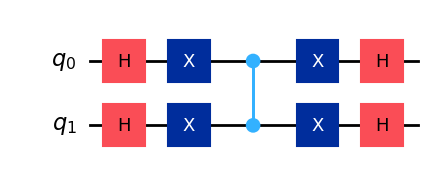

In [32]:
difusor = QuantumCircuit(2)
difusor.h([0, 1])
difusor.x([0, 1])
difusor.cz(0, 1)
difusor.x([0, 1])
difusor.h([0, 1])
difusor.draw('mpl')

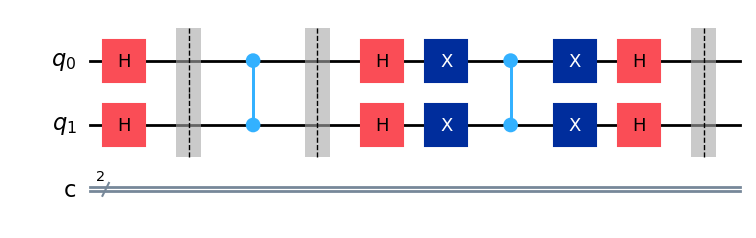

In [33]:
qc = qc.compose(difusor)
qc.barrier()
qc.draw('mpl')


#### Passo 4: Medição

Finalmente, medimos o estado do sistema quântico. Após a aplicação do oráculo e do difusor, o estado do sistema é $|11\rangle$ com probabilidade 100%. Portanto, ao medir os qubits, obtemos o resultado `11` com certeza.

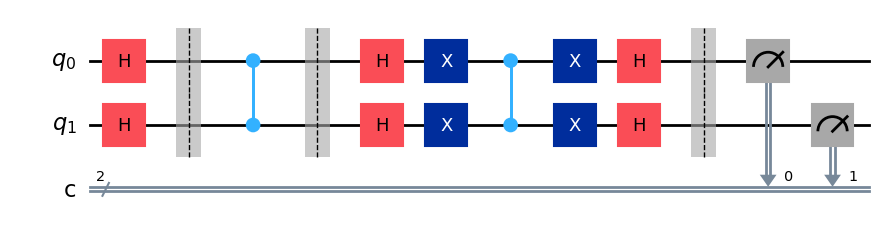

In [ ]:
# Finalização com medição nos qubits
qc.measure([0, 1], [0, 1])
qc.draw('mpl')

#### Passo 5: Execução do Circuito

Aqui o circuito é executado no simulador quântico, coletando os resultados das medições para verificar se o algoritmo funcionou conforme esperado.

In [ ]:
# --- EXECUÇÃO ---
simulador = AerSimulator()
job = simulador.run(transpile(qc, simulador), shots=1024)   
resultado = job.result().get_counts()

print("\n--- Resultado da Busca ---")
print(f"Contagens: {resultado}")
# Deve ser 100% (ou muito próximo) em '11'



--- Resultado da Busca ---
Contagens: {'11': 1024}
